# Imports 

In [1]:
# 1. Core PyTorch & Neural Network Engine
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# 2. Computer Vision & Pre-trained Models
import torchvision
from torchvision import datasets, transforms, models

# 3. OS & Numerical Operations
import os
import numpy as np

# 4. Data Visualization & Styling
import matplotlib.pyplot as plt
import seaborn as sns

# 5. Advanced Evaluation Metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Transforms

In [2]:
# Define the base path
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

# Standard normalization for models pre-trained on ImageNet
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

image_transforms = {
    # Train: Add augmentation to make the model more robust
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10), # Slight rotations for variety
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
    # Val/Test: No augmentation, just resize and normalize
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])
}

# Datasets and Loaders

In [3]:
# Create datasets using ImageFolder
full_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=image_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=image_transforms['val']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=image_transforms['test'])
}

# Create DataLoaders
# Batch size of 32 is a safe starting point for Kaggle GPUs
batch_size = 32

dataloaders = {
    'train': DataLoader(full_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(full_datasets['val'], batch_size=batch_size, shuffle=False),
    'test': DataLoader(full_datasets['test'], batch_size=batch_size, shuffle=False)
}

# Quick Check
dataset_sizes = {x: len(full_datasets[x]) for x in ['train', 'val', 'test']}
class_names = full_datasets['train'].classes

print(f"Dataset Sizes: {dataset_sizes}")
print(f"Class Names: {class_names}")

Dataset Sizes: {'train': 5216, 'val': 16, 'test': 624}
Class Names: ['NORMAL', 'PNEUMONIA']


# Visualizing a Batch

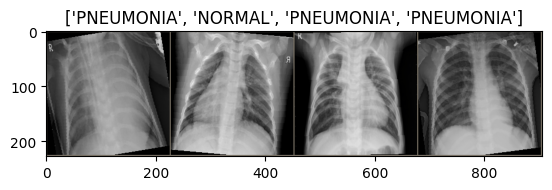

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.array(norm_std) * inp + np.array(norm_mean) # Un-normalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4]) # Show first 4 images

imshow(out, title=[class_names[x] for x in classes[:4]])

# CNN Architecture

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        
        # Using nn.Sequential to keep the architecture clean and readable
        self.network = nn.Sequential(
            # Block 1: Basic edge detection
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2), # Standard dropout to prevent overfitting

            # Block 2: Identifying mid-level textures/shapes
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            # Block 3: Complex pneumonia patterns
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3), # Slightly higher dropout for deeper features

            # Flattening the 3D feature maps into a 1D vector
            nn.Flatten(),

            # Fully Connected Head
            # If input is 224x224, after 3 poolings (224/2/2/2), size is 28x28
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2) # Final Output: Normal vs. Pneumonia
        )

    def forward(self, x):
        return self.network(x)

# Initialize the model
model = PneumoniaCNN().to(device)
print(model)

Using device: cuda
PneumoniaCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=100352, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=512, out_features=2, bias=True)
  )
)


# Training Loop

In [6]:
# 1. Setup Brain (Optimizer, Loss, Scheduler)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# 2. Storage for History
history = {
    'train_loss': [], 'val_loss': [], 'test_loss': [],
    'train_acc': [], 'val_acc': [], 'test_acc': [],
    'train_f1': [], 'val_f1': [], 'test_f1': []
}

epochs = 50

for epoch in range(epochs):
    # Each epoch has a training and validation phase
    for phase in ['train', 'val', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

        # Store metrics
        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc.item())
        history[f'{phase}_f1'].append(epoch_f1)

        if phase == 'val':
            scheduler.step(epoch_loss)

    print(f'Epoch {epoch+1}/{epochs} | Train Loss: {history["train_loss"][-1]:.4f} | '
          f'Val Acc: {history["val_acc"][-1]:.4f} | Test Acc: {history["test_acc"][-1]:.4f}')

Epoch 1/50 | Train Loss: 0.4477 | Val Acc: 0.8125 | Test Acc: 0.7981
Epoch 2/50 | Train Loss: 0.2314 | Val Acc: 0.6250 | Test Acc: 0.7340
Epoch 3/50 | Train Loss: 0.1945 | Val Acc: 0.8125 | Test Acc: 0.7564
Epoch 4/50 | Train Loss: 0.1806 | Val Acc: 0.7500 | Test Acc: 0.7772
Epoch 5/50 | Train Loss: 0.1692 | Val Acc: 0.6875 | Test Acc: 0.7564
Epoch 6/50 | Train Loss: 0.1461 | Val Acc: 0.6875 | Test Acc: 0.7548
Epoch 7/50 | Train Loss: 0.1181 | Val Acc: 0.7500 | Test Acc: 0.8109
Epoch 8/50 | Train Loss: 0.1139 | Val Acc: 0.8125 | Test Acc: 0.7708
Epoch 9/50 | Train Loss: 0.0989 | Val Acc: 0.6875 | Test Acc: 0.7692
Epoch 10/50 | Train Loss: 0.0969 | Val Acc: 0.7500 | Test Acc: 0.7692
Epoch 11/50 | Train Loss: 0.0890 | Val Acc: 0.7500 | Test Acc: 0.7708
Epoch 12/50 | Train Loss: 0.0872 | Val Acc: 0.7500 | Test Acc: 0.7740
Epoch 13/50 | Train Loss: 0.0875 | Val Acc: 0.7500 | Test Acc: 0.7692
Epoch 14/50 | Train Loss: 0.0911 | Val Acc: 0.6875 | Test Acc: 0.7676
Epoch 15/50 | Train Loss: 0.0

# Plotting 

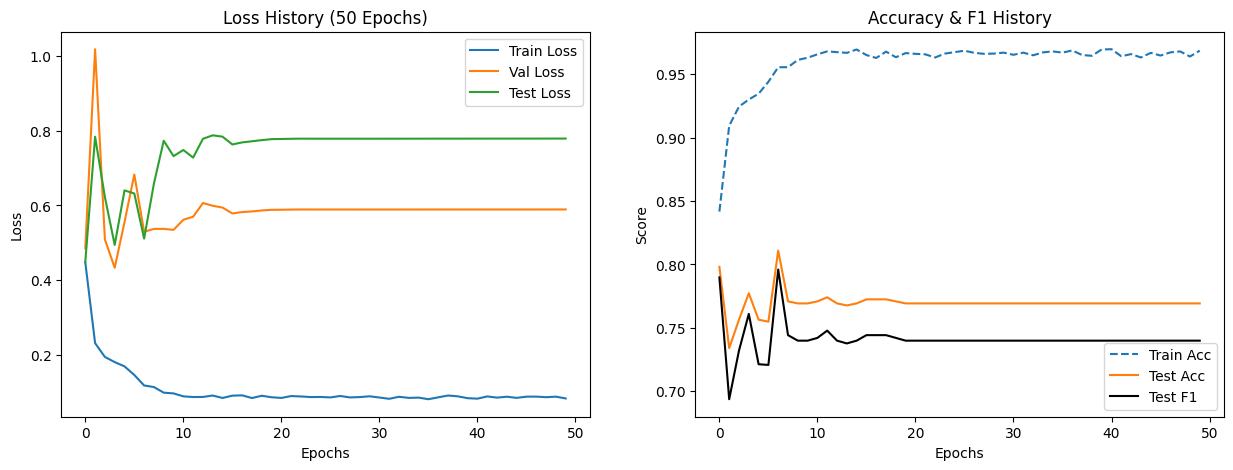

In [7]:
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Loss History (50 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy & F1
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc', linestyle='--')
plt.plot(history['test_acc'], label='Test Acc')
plt.plot(history['test_f1'], label='Test F1', color='black')
plt.title('Accuracy & F1 History')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.show()

# Evaluation

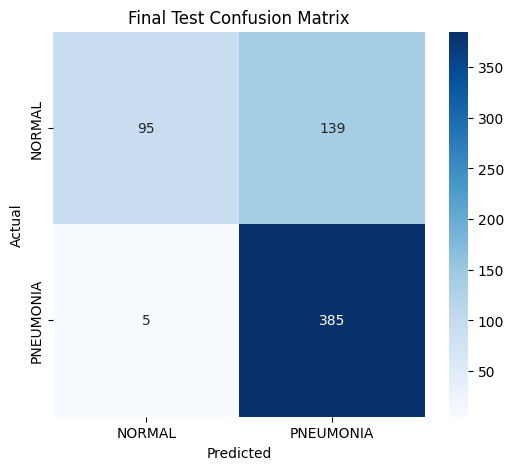

              precision    recall  f1-score   support

      NORMAL       0.95      0.41      0.57       234
   PNEUMONIA       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624



In [8]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORMAL', 'PNEUMONIA'], 
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Final Test Confusion Matrix')
plt.show()

# Final Test Report
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Prediction and Visualization

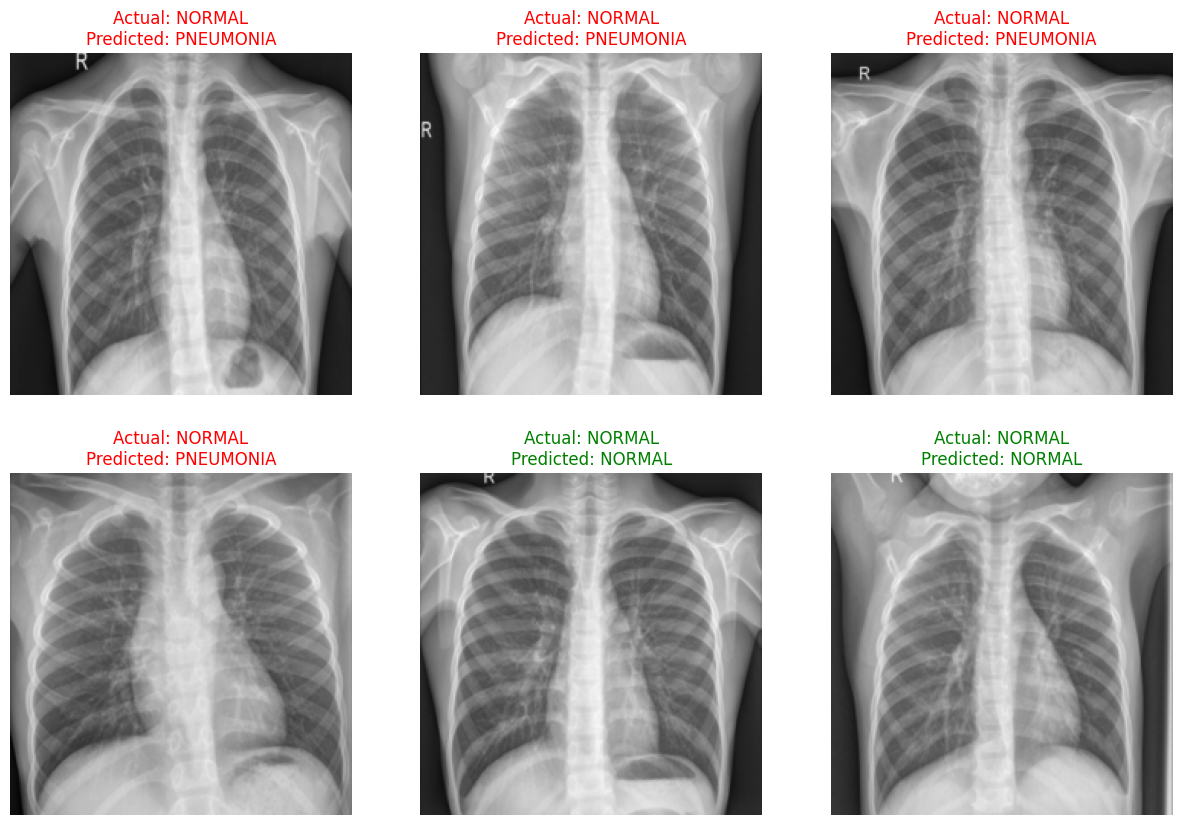

In [9]:
def visualize_predictions(model, dataloader, num_images=6):
    model.eval()  # Set to evaluation mode
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 3, 3, images_so_far)
                ax.axis('off')
                
                # Un-normalize for visualization
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                # Color code: Green if correct, Red if wrong
                title_color = "green" if preds[j] == labels[j] else "red"
                
                ax.imshow(img)
                ax.set_title(f"Actual: {class_names[labels[j]]}\nPredicted: {class_names[preds[j]]}", 
                             color=title_color)

                if images_so_far == num_images:
                    return

# Run it on your test loader
visualize_predictions(model, dataloaders['test'])

# Model Saving

In [10]:
torch.save(model.state_dict(), 'pneumonia_cnn_model.pth')
print("Model weights saved successfully!")

Model weights saved successfully!
